#Big Data
## Prachi Mehta (202318008)

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5d10478cbead4dc1a9e42b16b0b8c6d38bdbf7c457f15f0957254fda04e44655
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


**1. Setup and Data Preparation**

In [2]:
from pyspark.sql import SparkSession

In [4]:
# Initialize spark session
spark = SparkSession.builder.appName("Online News Popularity Prediction").getOrCreate()

# Load dataset into a pySpark dataframe
data = spark.read.option("header", "true").option("inferSchema", "true").csv("/content/OnlineNewsPopularity.csv")

# Display dataset
data.printSchema()


root
 |-- url: string (nullable = true)
 |--  timedelta: double (nullable = true)
 |--  n_tokens_title: double (nullable = true)
 |--  n_tokens_content: double (nullable = true)
 |--  n_unique_tokens: double (nullable = true)
 |--  n_non_stop_words: double (nullable = true)
 |--  n_non_stop_unique_tokens: double (nullable = true)
 |--  num_hrefs: double (nullable = true)
 |--  num_self_hrefs: double (nullable = true)
 |--  num_imgs: double (nullable = true)
 |--  num_videos: double (nullable = true)
 |--  average_token_length: double (nullable = true)
 |--  num_keywords: double (nullable = true)
 |--  data_channel_is_lifestyle: double (nullable = true)
 |--  data_channel_is_entertainment: double (nullable = true)
 |--  data_channel_is_bus: double (nullable = true)
 |--  data_channel_is_socmed: double (nullable = true)
 |--  data_channel_is_tech: double (nullable = true)
 |--  data_channel_is_world: double (nullable = true)
 |--  kw_min_min: double (nullable = true)
 |--  kw_max_min: do

**2. Data Preprocessing**

In [5]:
# Drop irrelevant data of url
data = data.drop("url")

# Drop rows with missing values
data = data.dropna()

# Convert the shares into binary outcome
median_shares = data.approxQuantile(" shares", [0.5], 0.01)[0]
data = data.withColumn("popularity", (data[" shares"] >= median_shares).cast("integer"))


**3. Exploratory Data Analysis (EDA)**

In [6]:
# Analyze characteristics of popular and non-popular articles
data.groupBy("popularity").count().show()

# Analyze distribution of key features
data.describe().show()

+----------+-----+
|popularity|count|
+----------+-----+
|         1|21154|
|         0|18490|
+----------+-----+

+-------+------------------+------------------+------------------+------------------+-----------------+-------------------------+------------------+------------------+-----------------+------------------+---------------------+------------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+--------------------------+--------------------------+---------------------------+-------------------+-------------------+---------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-

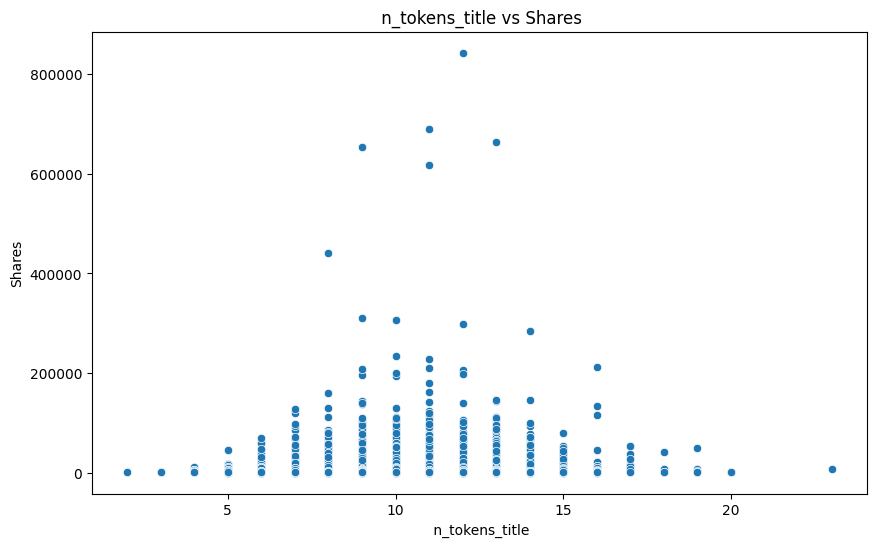

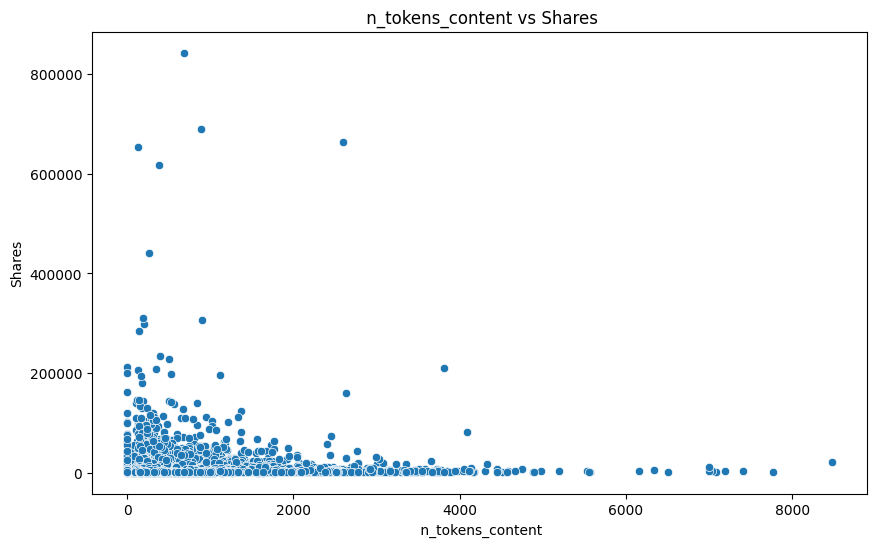

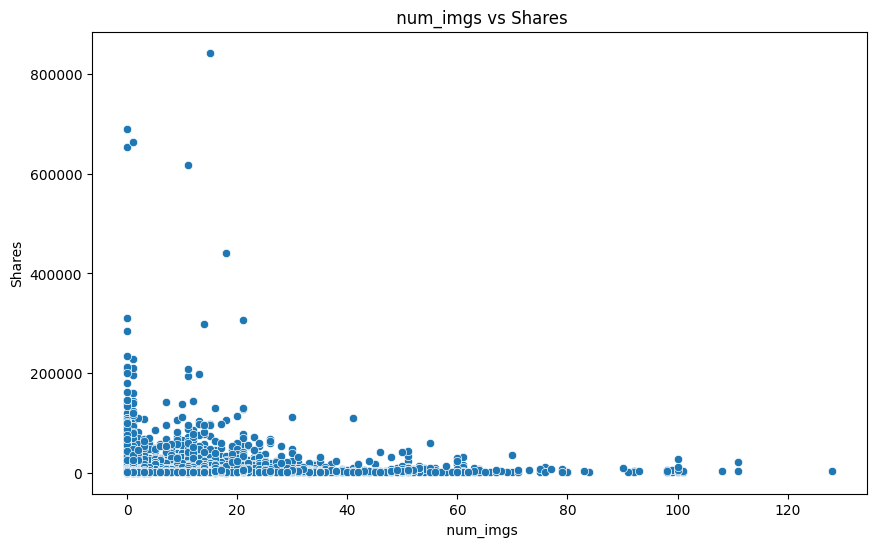

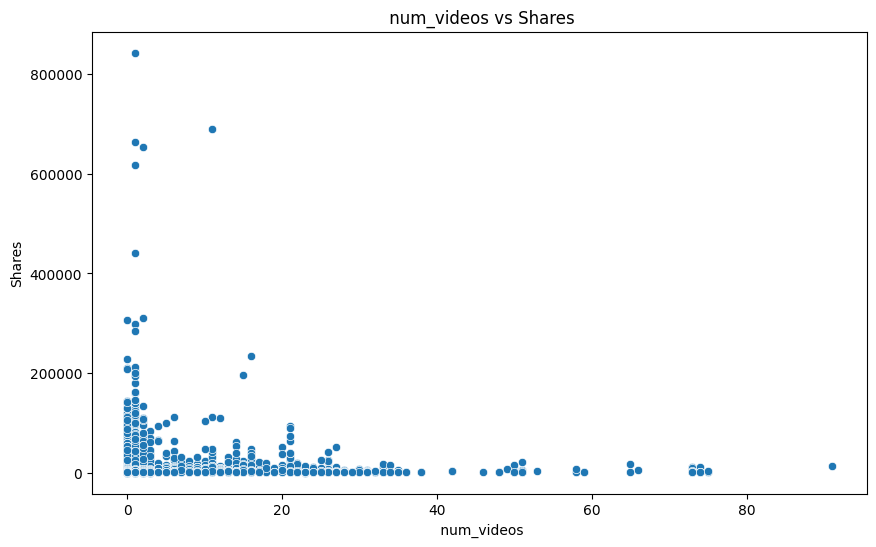

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Relationship between shares and other numerical features
numeric_features = [" n_tokens_title", " n_tokens_content", " num_imgs", " num_videos"]

for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data.toPandas(), x=feature, y=" shares")
    plt.title(f"{feature} vs Shares")
    plt.xlabel(feature)
    plt.ylabel("Shares")
    plt.show()

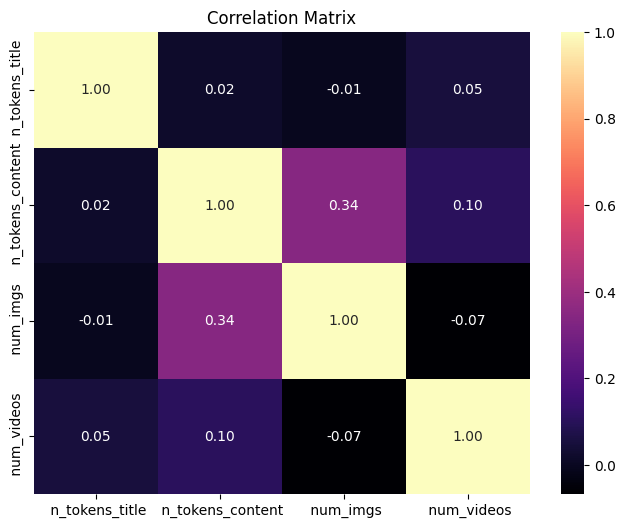

In [10]:
# Correlation matrix
numeric_data = data.select(*numeric_features)
correlation_matrix = numeric_data.toPandas().corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="magma", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


**4. Feature Engineering**

In [11]:
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import col

data = data.withColumnRenamed(" n_tokens_content", "n_tokens_content")
data = data.withColumn("n_tokens_content", col("n_tokens_content").cast("double"))
bucketizer = Bucketizer(splits=[0, 500, 1000, float('inf')], inputCol="n_tokens_content", outputCol="article_length_cat")

# Apply bucketizer to the data
data = bucketizer.transform(data)


**5. Model Building**

In [12]:
# Spliting dataset into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Train a classification model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

#  Create a feature vector
feature_cols = [col for col in data.columns if col not in [" shares", "popularity"]]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Initialize the model
lr = LogisticRegression(featuresCol="features", labelCol="popularity")

# Create a pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Train the model
model = pipeline.fit(train_data)

**6.  Model Evaluation**

In [13]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import expr

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="popularity")

# Calculate accuracy
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Analyze the confusion matrix
confusion_matrix = predictions.groupBy("popularity", "prediction").count()
confusion_matrix.show()


Accuracy: 0.7096706575597624
+----------+----------+-----+
|popularity|prediction|count|
+----------+----------+-----+
|         1|       0.0| 1248|
|         0|       0.0| 2235|
|         1|       1.0| 2901|
|         0|       1.0| 1441|
+----------+----------+-----+



**7. Advanced Analysis (ENSEMBLE METHODS)**

In [14]:
# Extract coefficients from the logistic regression model
coefficients = model.stages[-1].coefficients

feature_importance = [(feature_cols[i], coefficients[i]) for i in range(len(feature_cols))]

print("Feature Importance:")
for feature, importance in feature_importance:
    print(feature, importance)

Feature Importance:
 timedelta -1.7751853751820122e-05
 n_tokens_title 0.005129467697928589
n_tokens_content 0.00013586923650321783
 n_unique_tokens -0.21970427589021843
 n_non_stop_words 0.4781705494492787
 n_non_stop_unique_tokens -0.517783027189959
 num_hrefs 0.008771563290944159
 num_self_hrefs -0.016698734806955058
 num_imgs 0.001817847887692864
 num_videos -0.00035406069047767884
 average_token_length -0.09703006521835046
 num_keywords 0.044104140994508274
 data_channel_is_lifestyle -0.16236812723085756
 data_channel_is_entertainment -0.31513078476505557
 data_channel_is_bus -0.2110647501841119
 data_channel_is_socmed 0.8077175902448742
 data_channel_is_tech 0.4967558817577519
 data_channel_is_world 0.06992784763411362
 kw_min_min 0.0017711988079969728
 kw_max_min 2.573897711663453e-05
 kw_avg_min -0.000222309895544721
 kw_min_max -7.355438838191567e-07
 kw_max_max -4.075132040734127e-07
 kw_avg_max -5.495735574670244e-07
 kw_min_avg -8.554755932897333e-05
 kw_max_avg -8.68710096

In [15]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define the parameter grid for grid search
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

# Creating a cross-validator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

cv_model = crossval.fit(train_data)

# Get the best model from cross-validation
bestmodel = cv_model.bestModel

# Evaluate the best model
bestaccuracy = evaluator.evaluate(bestmodel.transform(test_data))
print("Best Accuracy after tuning:", bestaccuracy)


Best Accuracy after tuning: 0.7076572130468669


In [16]:
# Stop spark session
spark.stop()

### Challenges:

Performance: Working with large datasets can be computationally intensive, and optimizing code and configurations is crucial for performance.

Scalability: Ensuring that the chosen algorithms and Spark infrastructure can handle large-scale data efficiently.

### Insights:

Feature importance analysis can provide insights into which features are most influential in predicting the target variable. This can help in understanding the underlying patterns in the data.

Ensemble methods like random forests can often yield higher accuracy compared to simpler models like logistic regression, especially when the relationships between features and the target variable are complex.